In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import itertools
# Robust scaler is used to scale the features to median and IQR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import itertools

/Users/tugrul/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('results_new.csv')

print(df.dtypes)
# Need to convert ram_usage to numeric
df['ram_usage'] = pd.to_numeric(df['ram_usage'], errors='coerce')

# Find the NaN values in the DataFrame
# There could be NaN values due to some errors during the simulation
print(df.isna().sum())
# Drop the colums that includes nan in df
df = df.dropna()

simulation_number      int64
publisher_number       int64
subscriber_number      int64
message_size           int64
retain                  bool
qos                    int64
topics                 int64
ram_usage             object
database_size        float64
dtype: object
simulation_number    0
publisher_number     0
subscriber_number    0
message_size         0
retain               0
qos                  0
topics               0
ram_usage            2
database_size        4
dtype: int64


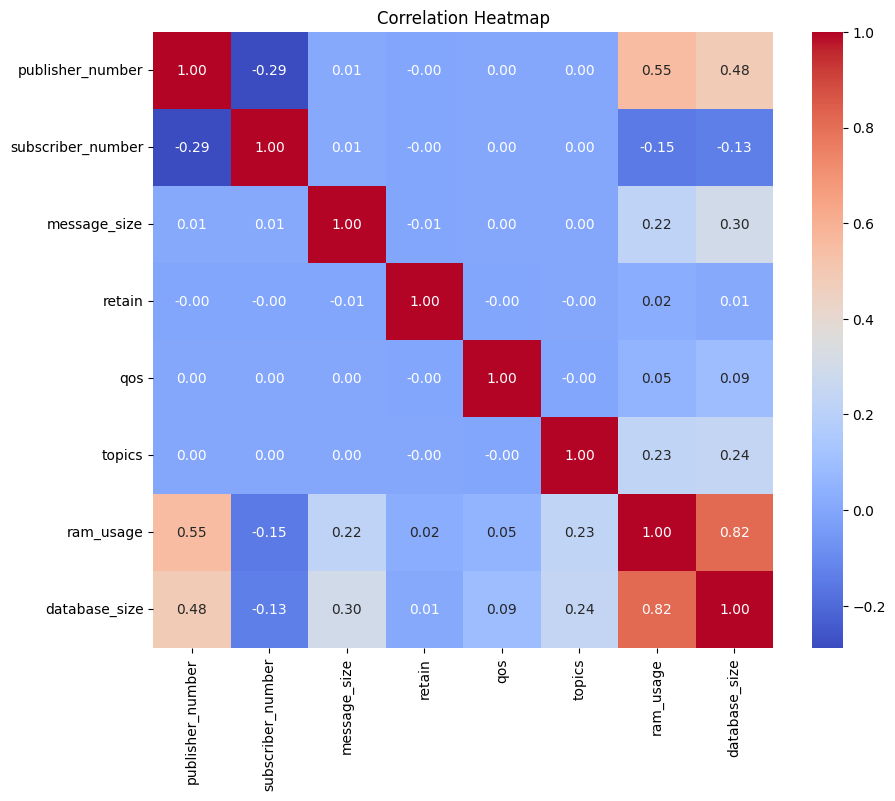

In [3]:
# Drop the columns that are not needed
df = df.drop(['simulation_number'], axis=1)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [4]:

# Convert message_size
df['message_size'] = df['message_size'].map({1024: 1, 2048: 2, 4096: 4, 8192: 8, 16384: 16})

# Convert ram_usage and database_size to kilobytes
df['ram_usage'] = df['ram_usage'] / 1024
df['database_size'] = df['database_size'] / 1024
#df = df[df['database_size'] <= 1000]
# convert retain from boolean to number
#df['retain'] = df['retain'].map({True: 1, False: 0})
# one hot encode the qos
df = pd.get_dummies(df, columns=['qos'])

In [5]:
print(df['publisher_number'].unique())
print(df['subscriber_number'].unique())
print(df['message_size'].unique())
print(df['retain'].unique())
print(df['topics'].unique())

[ 1  4  5  2  8 32 16  6  3  7]
[32  1  7  6  8  3  2 16  4  5]
[ 8 16  2  1  4]
[ True False]
[4 8 1]


In [6]:
df['database_size'].min(), df['database_size'].max()

(1.2, 12902.4)

In [7]:
# Normalize the data frame and save it in a different variable
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics', 'ram_usage', 'database_size']] = scaler.fit_transform(df[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics', 'ram_usage', 'database_size']])

# Split the data into training and testing sets
X = df_scaled[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics']]
y = df_scaled['database_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Build the neural network model
nn_model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
history = nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Predict on the test set with each model
lr_y_pred = model.predict(X_test_scaled)
rf_y_pred = rf_model.predict(X_test_scaled)
gb_y_pred = gb_model.predict(X_test_scaled)
xgb_y_pred = xgb_model.predict(X_test_scaled)
nn_y_pred = nn_model.predict(X_test_scaled).flatten()

# Evaluate the models
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

nn_mse = mean_squared_error(y_test, nn_y_pred)
nn_r2 = r2_score(y_test, nn_y_pred)

print(f'Linear Regression - Mean Squared Error: {lr_mse}, R^2 Score: {lr_r2}')
print(f'Random Forest - Mean Squared Error: {rf_mse}, R^2 Score: {rf_r2}')
print(f'Gradient Boosting - Mean Squared Error: {gb_mse}, R^2 Score: {gb_r2}')
print(f'XGBoost - Mean Squared Error: {xgb_mse}, R^2 Score: {xgb_r2}')
print(f'Neural Network - Mean Squared Error: {nn_mse}, R^2 Score: {nn_r2}')


/Users/tugrul/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Linear Regression - Mean Squared Error: 6.357664783283793, R^2 Score: 0.3868654294659436
Random Forest - Mean Squared Error: 2.764347786172086, R^2 Score: 0.7334056999768473
Gradient Boosting - Mean Squared Error: 2.3435877759699784, R^2 Score: 0.7739838866140993
XGBoost - Mean Squared Error: 5.065327516609213, R^2 Score: 0.5114987157428594
Neural Network - Mean Squared Error: 2.935166029450693, R^2 Score: 0.7169319515484323


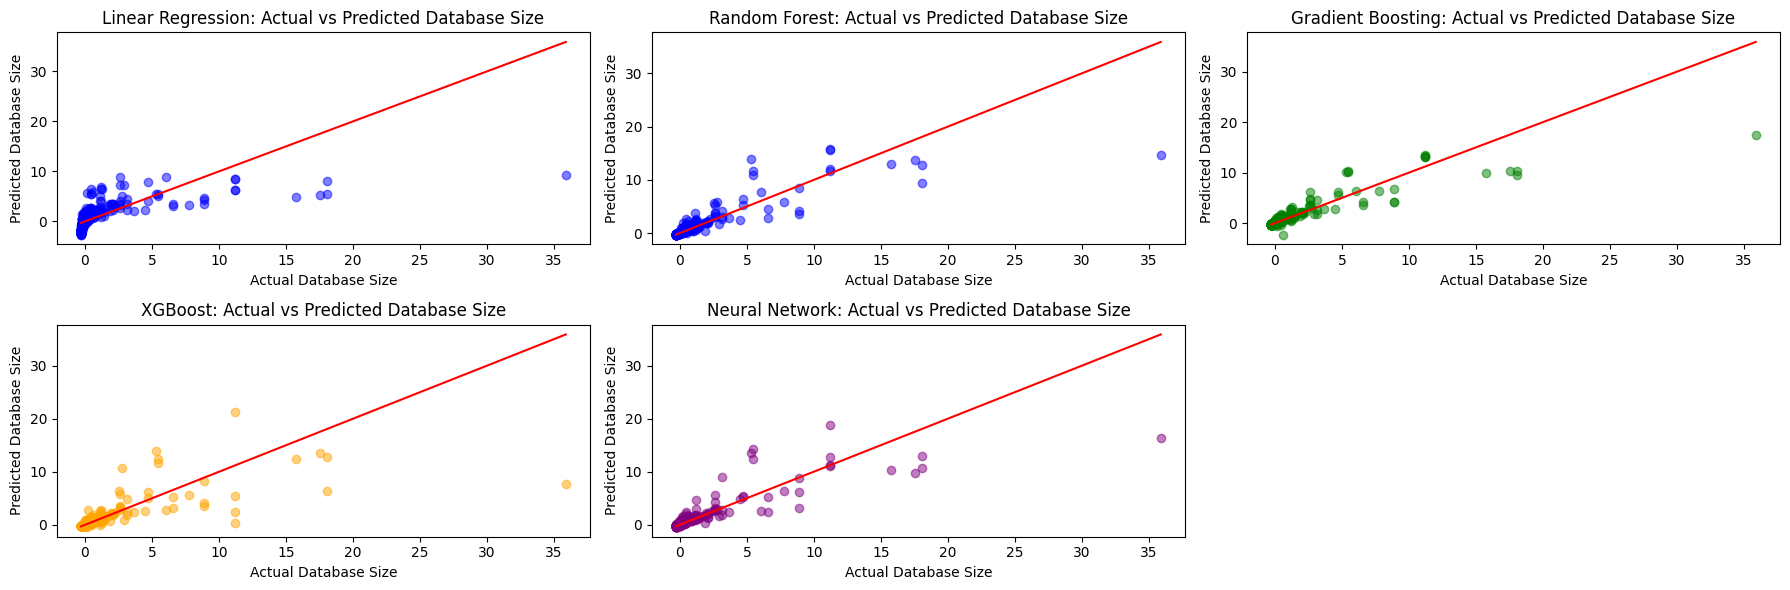

In [8]:
plt.figure(figsize=(18, 6))
# Linear Regression
plt.subplot(2, 3, 1)
plt.scatter(y_test, lr_y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Linear Regression: Actual vs Predicted Database Size')

# Random Forest
plt.subplot(2, 3, 2)
plt.scatter(y_test, rf_y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Random Forest: Actual vs Predicted Database Size')

# Gradient Boosting
plt.subplot(2, 3, 3)
plt.scatter(y_test, gb_y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Gradient Boosting: Actual vs Predicted Database Size')

# XGBoost
plt.subplot(2, 3, 4)
plt.scatter(y_test, xgb_y_pred, color='orange', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('XGBoost: Actual vs Predicted Database Size')

# Neural Network
plt.subplot(2, 3, 5)
plt.scatter(y_test, nn_y_pred, color='purple', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Neural Network: Actual vs Predicted Database Size')

plt.tight_layout()
plt.show()


In [9]:
df_scaled['database_size'].min(), df_scaled['database_size'].max()

(-0.28531390134529144, 72.03082959641254)

In [10]:
# Define the values for each input
publisher_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]
subscriber_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]
message_sizes = [1, 2, 4, 8, 16]
retains = [1, 0]
topics = range(1, 11)

# Define qos levels with only the specific combinations where one is True and the others are False
qos_levels = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

# Generate all combinations of the inputs, including one-hot encoded qos
combinations = [x + qos + (topic,) for x in itertools.product(publisher_numbers, subscriber_numbers, message_sizes, retains) for qos in qos_levels for topic in topics]

# Create a DataFrame from the combinations
input_data = pd.DataFrame(combinations, columns=['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics'])

# Use the same RobustScaler initialized and fitted previously
# Assuming 'scaler' is the RobustScaler instance fitted with your full dataset
# Transform the new data
input_data_scaled = scaler.transform(input_data[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics']])

# Predict database sizes for the combinations using Gradient Boosting
input_data['predicted_database_size'] = gb_model.predict(input_data_scaled)

# Convert one-hot encoded qos back to a single column
input_data['qos'] = input_data['qos_0'] + 2 * input_data['qos_1'] + 3 * input_data['qos_2'] - 1  # -1 to shift from 0, 1, 2

# Display the catalog
display(input_data[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos', 'topics', 'predicted_database_size']])

# Optionally, save the catalog to a CSV file
input_data[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos', 'topics', 'predicted_database_size']].to_csv('gb_combinations_catalog_new_features.csv', index=False)


,publisher_number,subscriber_number,message_size,retain,qos,topics,predicted_database_size
0,1,1,1,1,0,1,1.724722
1,1,1,1,1,0,2,1.724722
2,1,1,1,1,0,3,1.724722
3,1,1,1,1,0,4,1.724722
4,1,1,1,1,0,5,1.724722
...,...,...,...,...,...,...,...
36295,64,64,16,0,2,6,33.146425
36296,64,64,16,0,2,7,33.146425
36297,64,64,16,0,2,8,33.146425
36298,64,64,16,0,2,9,33.146425


In [11]:
# Remove the outliers from the dataset
df = df[df['database_size'] <= 1000]

# Normalize the data frame and save it in a different variable
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics', 'ram_usage', 'database_size']] = scaler.fit_transform(df[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics', 'ram_usage', 'database_size']])

# Split the data into training and testing sets
X = df_scaled[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos_0', 'qos_1', 'qos_2', 'topics']]
y = df_scaled['database_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Build the neural network model
nn_model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
history = nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Predict on the test set with each model
lr_y_pred = model.predict(X_test_scaled)
rf_y_pred = rf_model.predict(X_test_scaled)
gb_y_pred = gb_model.predict(X_test_scaled)
xgb_y_pred = xgb_model.predict(X_test_scaled)
nn_y_pred = nn_model.predict(X_test_scaled).flatten()

# Evaluate the models
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

nn_mse = mean_squared_error(y_test, nn_y_pred)
nn_r2 = r2_score(y_test, nn_y_pred)

print(f'Linear Regression - Mean Squared Error: {lr_mse}, R^2 Score: {lr_r2}')
print(f'Random Forest - Mean Squared Error: {rf_mse}, R^2 Score: {rf_r2}')
print(f'Gradient Boosting - Mean Squared Error: {gb_mse}, R^2 Score: {gb_r2}')
print(f'XGBoost - Mean Squared Error: {xgb_mse}, R^2 Score: {xgb_r2}')
print(f'Neural Network - Mean Squared Error: {nn_mse}, R^2 Score: {nn_r2}')

/Users/tugrul/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Linear Regression - Mean Squared Error: 0.8292451503301818, R^2 Score: 0.6068314689125254
Random Forest - Mean Squared Error: 0.27210327248214106, R^2 Score: 0.8709881584434942
Gradient Boosting - Mean Squared Error: 0.2918037957243154, R^2 Score: 0.8616475843301621
XGBoost - Mean Squared Error: 0.2746200335416273, R^2 Score: 0.8697948909900006
Neural Network - Mean Squared Error: 0.37636461467598326, R^2 Score: 0.8215549133491581


In [12]:
# Try gradient boosting with different hyperparameters
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=20, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_y_pred = gb_model.predict(X_test_scaled)
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)
print(f'Gradient Boosting - Mean Squared Error: {gb_mse}, R^2 Score: {gb_r2}')

# Try XGBoost with different hyperparameters
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=20, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_y_pred = xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)
print(f'XGBoost - Mean Squared Error: {xgb_mse}, R^2 Score: {xgb_r2}')

# Try neural network with different hyperparameters
nn_model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = nn_model.fit(X_train_scaled, y_train, epochs=200, batch_size=10, validation_split=0.2, verbose=0)
nn_y_pred = nn_model.predict(X_test_scaled).flatten()
nn_mse = mean_squared_error(y_test, nn_y_pred)
nn_r2 = r2_score(y_test, nn_y_pred)
print(f'Neural Network - Mean Squared Error: {nn_mse}, R^2 Score: {nn_r2}')

Gradient Boosting - Mean Squared Error: 0.7235862588978444, R^2 Score: 0.6569273315464429
XGBoost - Mean Squared Error: 0.3662678768413089, R^2 Score: 0.8263420617354388


/Users/tugrul/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Neural Network - Mean Squared Error: 0.5358717759981173, R^2 Score: 0.7459280661014104
